## Step 1: Feature Transformation

In [326]:
# Importing Libraries
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [327]:
# paths 
INP = Path("../data_work/loans_cleaned.parquet")
OUT = Path("../data_work/loans_fe.parquet")
RESULTS = Path("../results"); RESULTS.mkdir(exist_ok=True, parents=True)

In [328]:
# 1) Load cleaned data
df = pd.read_parquet(INP)
df.head()

,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,annual_inc,dti,fico,grade,sub_grade,emp_length,home_ownership,purpose,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,target
0,40932667,2015-02-01,2015-01-01,28000,60,0.0999,594.780029,103000.0,9.980000,685,b,b3,10.0,rent,debt_consolidation,18666.621,5.533333,235.355,0.11,0
1,41120433,2015-02-01,2015-01-01,10300,60,0.1399,239.610001,42000.0,31.559999,720,c,c4,6.0,mortgage,credit_card,18666.621,5.533333,235.355,0.11,0
2,40959606,2015-02-01,2015-01-01,35000,60,0.1786,886.109985,100000.0,18.120001,720,d,d5,10.0,mortgage,home_improvement,18666.621,5.533333,235.355,0.11,0
3,41143031,2015-02-01,2015-01-01,15000,36,0.0692,462.609985,125000.0,32.150002,700,a,a4,4.0,mortgage,debt_consolidation,18666.621,5.533333,235.355,0.11,0
4,40932682,2015-02-01,2015-01-01,35000,60,0.1699,869.659973,100000.0,20.340000,710,d,d3,3.0,mortgage,credit_card,18666.621,5.533333,235.355,0.11,0


In [329]:
# 2) Drop identifiers / leakage
for c in ["id", "issue_d", "sub_grade"]:
    if c in df.columns:
        df.drop(columns=c, inplace=True)


In [330]:
df.columns

Index(['issue_q_start', 'loan_amnt', 'term_m', 'int_rate', 'installment',
       'annual_inc', 'dti', 'fico', 'grade', 'emp_length', 'home_ownership',
       'purpose', 'GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'target'],
      dtype='object')

In [331]:
# 3) # Keep only one clean DTI column
if "debt_to_income_ratio" in df.columns:
    df.drop(columns=["debt_to_income_ratio"], inplace=True)

# Ensure dtype consistency
df["dti"] = pd.to_numeric(df["dti"], errors="coerce").astype("float32")


In [332]:
# 4) Ensure log income exists (useful + stable)
if "log_annual_inc" not in df.columns and "annual_inc" in df.columns:
    df["log_annual_inc"] = np.log1p(pd.to_numeric(df["annual_inc"], errors="coerce"))
    df.drop(columns=["annual_inc"], inplace=True)

In [333]:
# 5) Minimal numeric NA fill (only if present)
num_cols = df.select_dtypes(include=[np.number]).columns
if df[num_cols].isna().any().any():
    df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.median()))

In [334]:
# 6) One-hot encode compact categoricals (drop_first to avoid dummy trap)
cat_cols = [c for c in ["grade", "home_ownership", "purpose"] if c in df.columns]
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, prefix=cat_cols)

In [335]:
df.head(2)

,issue_q_start,loan_amnt,term_m,int_rate,installment,dti,fico,emp_length,GDPC1,UNRATE,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,2015-01-01,28000,60,0.0999,594.780029,9.980000,685,10.0,18666.621,5.533333,...,False,False,False,False,False,False,False,False,False,False
1,2015-01-01,10300,60,0.1399,239.610001,31.559999,720,6.0,18666.621,5.533333,...,False,False,False,False,False,False,False,False,False,False


In [336]:
df.columns

Index(['issue_q_start', 'loan_amnt', 'term_m', 'int_rate', 'installment',
       'dti', 'fico', 'emp_length', 'GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS',
       'target', 'log_annual_inc', 'grade_b', 'grade_c', 'grade_d', 'grade_e',
       'grade_f', 'grade_g', 'home_ownership_mortgage', 'home_ownership_none',
       'home_ownership_other', 'home_ownership_own', 'home_ownership_rent',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [337]:
print("Step 1 complete — transformed shape:", df.shape)

Step 1 complete — transformed shape: (2258953, 38)


## 2. Feature Construction

In [338]:
# 1) Macro QoQ deltas (by issue_q_start)
if "issue_q_start" in df.columns:
    df.sort_values(["issue_q_start"], inplace=True)
    for col in ["UNRATE","FEDFUNDS","GDPC1","CPIAUCSL"]:
        if col in df.columns:
            delta_name = f"{col}_delta_qoq"
            qavg = df.groupby("issue_q_start")[col].mean().sort_index().pct_change()
            df = df.merge(qavg.rename(delta_name), left_on="issue_q_start", right_index=True, how="left")

    if "int_rate" in df.columns and "CPIAUCSL_delta_qoq" in df.columns:
        df["inflation_qoq"] = df["CPIAUCSL_delta_qoq"]
        df.drop(columns=['CPIAUCSL_delta_qoq'], inplace=True)
        df["real_rate_qoq"] = df["int_rate"] - df["inflation_qoq"]


In [339]:
# 2) Clean infinities/new NaNs from constructed fields; light fills
for c in ["inflation_qoq","real_rate_qoq",
          "UNRATE_delta_qoq","FEDFUNDS_delta_qoq","GDPC1_delta_qoq","CPIAUCSL_delta_qoq"]:
    if c in df.columns:
        df[c] = df[c].replace([np.inf, -np.inf], np.nan)
        df[c] = df[c].fillna(0.0 if c.endswith("_qoq") else df[c].median())

In [340]:
print("Step 2 complete — constructed shape:", df.shape)


Step 2 complete — constructed shape: (2258953, 43)


## 3. Feature Selection (Statistical: variance + correlation)

In [341]:
# 1) Identify numeric feature columns (exclude target)
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != "target"]


In [342]:
num_cols

['loan_amnt',
 'term_m',
 'int_rate',
 'installment',
 'dti',
 'fico',
 'GDPC1',
 'UNRATE',
 'CPIAUCSL',
 'FEDFUNDS',
 'log_annual_inc',
 'UNRATE_delta_qoq',
 'FEDFUNDS_delta_qoq',
 'GDPC1_delta_qoq',
 'inflation_qoq',
 'real_rate_qoq']

In [343]:
df.head()

,issue_q_start,loan_amnt,term_m,int_rate,installment,dti,fico,emp_length,GDPC1,UNRATE,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,UNRATE_delta_qoq,FEDFUNDS_delta_qoq,GDPC1_delta_qoq,inflation_qoq,real_rate_qoq
1271740,2007-04-01,7500,36,0.1375,255.429993,14.29,660,0.5,16713.314,4.5,...,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0
1274464,2007-04-01,6000,36,0.1059,195.279999,12.90,695,0.5,16713.314,4.5,...,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0
1274465,2007-04-01,4400,36,0.0964,141.250000,3.72,695,2.0,16713.314,4.5,...,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0
1274466,2007-04-01,1200,36,0.0901,38.169998,3.27,705,0.5,16713.314,4.5,...,True,False,False,False,False,0.0,0.0,0.0,0.0,0.0
1274467,2007-04-01,5000,36,0.1122,164.229996,3.51,670,0.5,16713.314,4.5,...,True,False,False,False,False,0.0,0.0,0.0,0.0,0.0


In [344]:
# 2) Low-variance / near-constant feature filter (with protection list)
# Columns we never drop here (economically meaningful even if low variance)
protected = {
    "int_rate", "dti", "fico", "log_annual_inc",
    "GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS",
    "GDPC1_delta_qoq", "UNRATE_delta_qoq", "CPIAUCSL_delta_qoq",
    "inflation_qoq", "real_rate_qoq"
}

candidate_cols = df.select_dtypes(include=["number", "bool"]).columns

flagged, dropped = [], []

for c in candidate_cols:
    if c in protected:
        continue  # never drop protected features

    nunique = df[c].nunique()
    var = df[c].var()

    # Drop only:
    #  - perfectly constant numerics (nunique <= 1)
    #  - near-constant booleans (very sparse or very dense)
    if nunique <= 1:
        flagged.append((c, "constant"))
        dropped.append(c)
    elif df[c].dtype == "bool":
        p = df[c].mean()  # share of True
        if p < 0.01 or p > 0.99:
            flagged.append((c, f"bool near-constant (p_true={p:.4f})"))
            dropped.append(c)
    # NOTE: We intentionally do NOT drop low-variance continuous numerics here.

if dropped:
    print(f"Dropping {len(dropped)} near-constant features (unprotected):", dropped)
    df.drop(columns=dropped, inplace=True)
else:
    print("No near-constant (unprotected) features found.")

# Optional: show what was flagged and why
if flagged:
    print("Flagged features (reason):")
    for name, reason in flagged:
        print(f"  - {name}: {reason}")

Dropping 9 near-constant features (unprotected): ['grade_g', 'home_ownership_none', 'home_ownership_other', 'purpose_educational', 'purpose_house', 'purpose_moving', 'purpose_renewable_energy', 'purpose_vacation', 'purpose_wedding']
Flagged features (reason):
  - grade_g: bool near-constant (p_true=0.0054)
  - home_ownership_none: bool near-constant (p_true=0.0000)
  - home_ownership_other: bool near-constant (p_true=0.0001)
  - purpose_educational: bool near-constant (p_true=0.0002)
  - purpose_house: bool near-constant (p_true=0.0063)
  - purpose_moving: bool near-constant (p_true=0.0068)
  - purpose_renewable_energy: bool near-constant (p_true=0.0006)
  - purpose_vacation: bool near-constant (p_true=0.0069)
  - purpose_wedding: bool near-constant (p_true=0.0010)


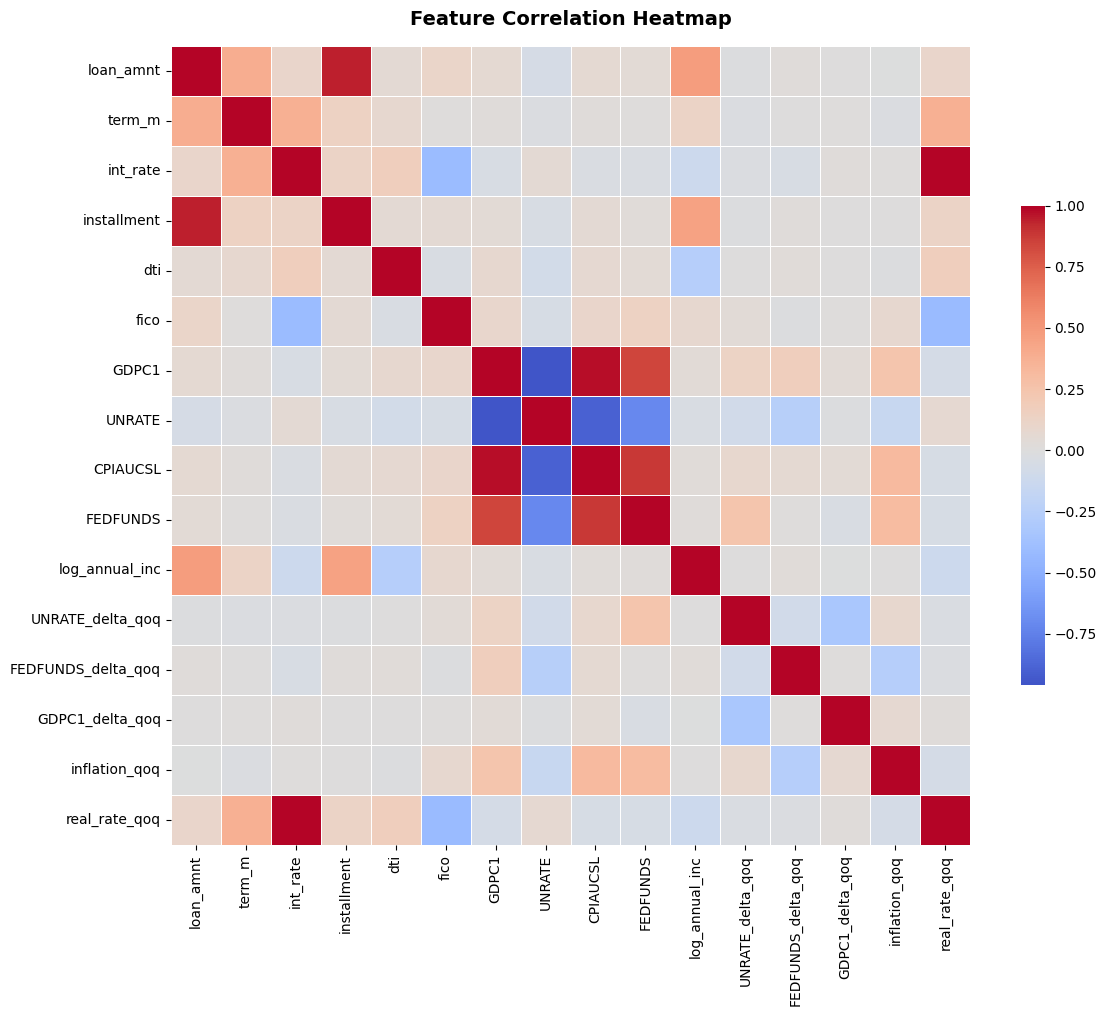

In [345]:
# 3) Heatmap to show correlation of numeric attributes
plt.figure(figsize=(12,10))
corr = df[num_cols].corr()

sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.6},)
plt.title("Feature Correlation Heatmap", fontsize=14, weight="bold", pad=15)
plt.tight_layout()
plt.savefig("../results/figures/feature_correlation_heatmap.png", dpi=300)
plt.show()

In [346]:
# 4) Informed Correlation Filter (|r| > 0.85) — prefer to keep interpretable / stable features
corr_matrix = df[num_cols].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Preferred features to KEEP if correlated with others
preferred_keep = [
    "log_annual_inc", "loan_amnt", "loan_to_income",
    "term_60", "GDPC1", "CPIAUCSL",
    "FEDFUNDS_delta_qoq", "UNRATE_delta_qoq",
    "real_rate_qoq", "fico"
]

to_drop_corr = set()

for col in upper_tri.columns:
    # Find all other columns that are highly correlated with this one
    correlated_feats = upper_tri.index[upper_tri[col] > 0.85].tolist()
    for corr_col in correlated_feats:
        # Decide which one to drop based on the preferred list
        if corr_col in preferred_keep and col not in preferred_keep:
            to_drop_corr.add(col)
        elif col in preferred_keep and corr_col not in preferred_keep:
            to_drop_corr.add(corr_col)
        else:
            # If neither is preferred, drop the second (arbitrary rule to break ties)
            to_drop_corr.add(corr_col)

if to_drop_corr:
    to_drop_corr = list(to_drop_corr)
    print(f"Dropping {len(to_drop_corr)} highly correlated features (|r|>0.85):", to_drop_corr)
    df.drop(columns=to_drop_corr, inplace=True)
else:
    print("No highly correlated features above threshold found.")


Dropping 5 highly correlated features (|r|>0.85): ['UNRATE', 'GDPC1', 'installment', 'int_rate', 'FEDFUNDS']


In [347]:
# 4) Print resulting dimensionality
print(f"Step 3 complete — selected features: {df.shape[1]} columns total")

Step 3 complete — selected features: 29 columns total


In [348]:
# To show top correlated remaining pairs for inspection
corr_pairs = (
    corr_matrix.stack()
    .reset_index()
    .rename(columns={"level_0":"Feature1","level_1":"Feature2",0:"Correlation"})
)

print("\nTop remaining correlations:")
display(corr_pairs.sort_values(by="Correlation", ascending=False).head(10))



Top remaining correlations:


,Feature1,Feature2,Correlation
0,loan_amnt,loan_amnt,1.0
17,term_m,term_m,1.0
238,inflation_qoq,inflation_qoq,1.0
221,GDPC1_delta_qoq,GDPC1_delta_qoq,1.0
204,FEDFUNDS_delta_qoq,FEDFUNDS_delta_qoq,1.0
187,UNRATE_delta_qoq,UNRATE_delta_qoq,1.0
170,log_annual_inc,log_annual_inc,1.0
153,FEDFUNDS,FEDFUNDS,1.0
136,CPIAUCSL,CPIAUCSL,1.0
119,UNRATE,UNRATE,1.0


In [349]:
df.columns

Index(['issue_q_start', 'loan_amnt', 'term_m', 'dti', 'fico', 'emp_length',
       'CPIAUCSL', 'target', 'log_annual_inc', 'grade_b', 'grade_c', 'grade_d',
       'grade_e', 'grade_f', 'home_ownership_mortgage', 'home_ownership_own',
       'home_ownership_rent', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_medical', 'purpose_other',
       'purpose_small_business', 'UNRATE_delta_qoq', 'FEDFUNDS_delta_qoq',
       'GDPC1_delta_qoq', 'inflation_qoq', 'real_rate_qoq'],
      dtype='object')

In [350]:
df.to_parquet(OUT, index=False)

In [351]:
print(f"Final Data Shape: {df.shape}")

Final Data Shape: (2258953, 29)
